In [16]:
%matplotlib inline

import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiime2 import Metadata, Artifact
from qiime2.plugins import deicode, feature_table
from skbio.stats.ordination import OrdinationResults

First, I want to poke around the original feature table to make sure things look good.

In [5]:
%%bash
source activate rpca_cooc

qiime tools import \
--input-path ../data/raw/qiita103/trim100/44765_otu_table.biom \
--output-path ../data/raw/qiita103/trim100/44765_otu_table.qza \
--type FeatureTable[Frequency]

Imported ../data/raw/qiita103/trim100/44765_otu_table.biom as BIOMV210DirFmt to ../data/raw/qiita103/trim100/44765_otu_table.qza


In [7]:
feat_table = Artifact.load("../data/raw/qiita103/trim100/44765_otu_table.qza")
feat_table_df = feat_table.view(pd.DataFrame)
print(feat_table_df.shape)
feat_table_df.head()

(89, 9324)


,4479946,547831,4436710,244331,4479940,4355812,1124709,561174,1126562,623634,...,4440143,834567,4326975,556028,770450,1673347,160412,222810,3893085,2063454
103.LQ3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
103.PE4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103.MT2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103.SK1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103.AR1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
meta = Metadata.load("../data/raw/qiita103/103_20171215-103619.txt")
meta.to_dataframe().head()

,annual_season_precpt,annual_season_temp,anonymized_name,carb_nitro_ratio,cmin_rate,collection_date,country,depth,description,dna_extracted,...,qiita_study_id,sample_type,silt_clay,soil_moisture_deficit,soil_type,specific_location,texture,title,tot_org_carb,tot_org_nitro
sample_name,,,,,,,,,,,,,,,,,,,,,
103.AR1,1400.0,23.0,AR1,8.980,4.300,2008.0,GAZ:Argentina,0-0.05,soil metagenome,true,...,103.0,XXQIITAXX,80.0,-206.0,oxisol,"Misiones, Argentina",clay,Pyrosequencing-Based Assessment of Soil pH as ...,22.10,0.0
103.AR2,1400.0,23.0,AR2,9.360,3.900,2008.0,GAZ:Argentina,0-0.05,soil metagenome,true,...,103.0,XXQIITAXX,78.0,-206.0,oxisol,"Misiones, Argentina",clay,Pyrosequencing-Based Assessment of Soil pH as ...,21.70,0.0
103.AR3,1400.0,23.0,AR3,9.844,4.500,2008.0,GAZ:Argentina,0-0.05,soil metagenome,true,...,103.0,XXQIITAXX,82.0,-206.0,oxisol,"Misiones, Argentina",clay,Pyrosequencing-Based Assessment of Soil pH as ...,24.40,0.0
103.BB1,1200.0,6.1,BB1,20.500,4.300,2008.0,GAZ:United States of America,0-0.05,soil metagenome,true,...,103.0,XXQIITAXX,41.0,-680.2,spodosol,"Bear Brook, ME",sandy loam,Pyrosequencing-Based Assessment of Soil pH as ...,12.84,0.0
103.BB2,1200.0,6.1,BB2,21.400,2.223,2008.0,GAZ:United States of America,0-0.05,soil metagenome,true,...,103.0,XXQIITAXX,44.0,-680.2,spodosol,"Bear Brook, ME, USA",sandy loam,Pyrosequencing-Based Assessment of Soil pH as ...,52.20,0.0


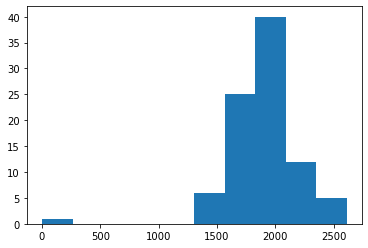

In [9]:
plt.hist(np.sum(feat_table_df, axis=1))

plt.show()

Looks like one of the samples has an incredibly low read-depth - I will exclude this sample from the processed table.

In [10]:
feat_table_df.sum(axis=1).tail()

103.CF2    1610.0
103.HF1    2005.0
103.MP2    1945.0
103.CF3    1490.0
103.BB1       2.0
dtype: float64

In [11]:
feat_table_filt = feature_table.methods.filter_samples(
    table=feat_table,
    metadata=meta,
    where="sample_name == '103.BB1'",
    exclude_ids=True,
).filtered_table

In [12]:
feat_table_filt_df = feat_table_filt.view(pd.DataFrame)
print(feat_table_filt_df.shape)
feat_table_filt_df.head()

(88, 9324)


,4479946,547831,4436710,244331,4479940,4355812,1124709,561174,1126562,623634,...,4440143,834567,4326975,556028,770450,1673347,160412,222810,3893085,2063454
103.LQ3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
103.PE4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103.MT2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103.SK1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103.AR1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


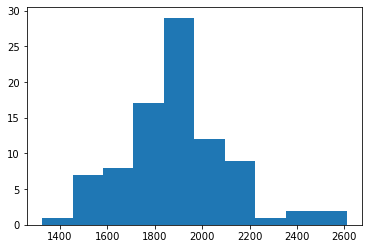

In [13]:
plt.hist(np.sum(feat_table_filt_df, axis=1))

plt.show()

Better. I'll use this feature table for generating synthetic data using SpiecEasi.

In [14]:
feat_table_filt.save("../data/processed/qiita103/88_soils_filt.qza")
feat_table_filt_df.to_csv("../data/processed/qiita103/88_soils_filt.csv", index=True)

In [15]:
ordination, samp_dist, feat_dist = deicode.actions.rpca(
    table=feat_table_filt,
    n_components=2,
)

/home/grahman/.conda/envs/rpca_cooc/lib/python3.6/site-packages/biom/table.py:4049: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  for r in self.matrix_data.tocsr()]
/home/grahman/.conda/envs/rpca_cooc/lib/python3.6/site-packages/biom/table.py:4052: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/home/grahman/.conda/envs/rpca_cooc/lib/python3.6/site-packages/pandas/core/sparse/frame.py:854: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are Spars

In [19]:
ordination_df = ordination.view(OrdinationResults).samples
ordination_df.drop(columns=[2], inplace=True)
ordination_df.rename(columns={0: "PC1", 1: "PC2"}, inplace=True)
assert ordination_df.shape == (88, 2)

ordination_df.head()

,PC1,PC2
103.LQ3,-0.131182,-0.097376
103.PE4,-0.174521,-0.143703
103.MT2,0.008419,0.136729
103.SK1,-0.089094,0.161165
103.AR1,0.054457,0.010671


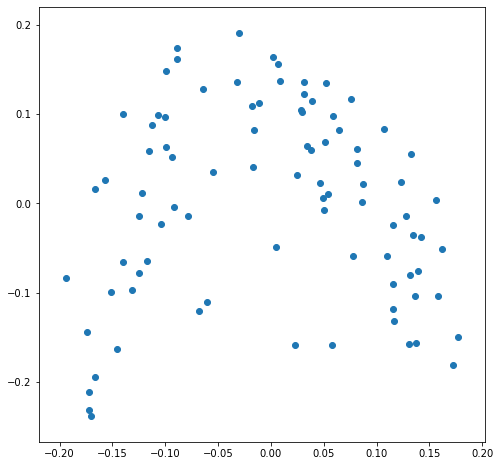

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(
    ordination_df["PC1"],
    ordination_df["PC2"],
)

plt.show()